In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wmfdata as wmf

from wmfdata.utils import (
    pct_str, 
    pd_display_all
)

In [30]:
wmf.charting.set_mpl_style()

The experiment was released to the KaiOS store on 8 April, in version 1.6.0 of the app. On 5 May, we [fixed](https://www.mediawiki.org/w/index.php?title=Wikipedia_for_KaiOS/engagement1&diff=4563366&oldid=4520262) a vandalization of our config that prevent the recommendations from being shown.

# Data storage

Log of updates:
* 2021-07-29: stored data for \[2021-05-06, 2021-07-27\]

In [6]:
HIVE_PARTITION_DATE = (
    "CONCAT("
        "CAST(year AS STRING), '-', "
        "LPAD(CAST(month AS STRING), 2, '0'), '-', "
        "LPAD(CAST(day AS STRING), 2, '0')"
    ")"
)

PRESTO_PARTITION_DATE = (
    "CONCAT("
        "CAST(year AS VARCHAR), '-', "
        "LPAD(CAST(month AS VARCHAR), 2, '0'), '-', "
        "LPAD(CAST(day AS VARCHAR), 2, '0')"
    ")"
)

# Both start and end dates are included
START_DATE = "2021-05-06"
END_DATE = "2021-07-27"

In [ ]:
wmf.spark.run("""
CREATE TABLE neilpquinn.kaios_experiment_event (
    client_dt STRING,
    server_dt STRING,
    pageview_id STRING,
    session_id STRING,
    user_id STRING,
    load_dt STRING,
    page_open_time BIGINT,
    page_visible_time BIGINT,
    section_count BIGINT,
    opened_section_count BIGINT,
    is_main_page BOOLEAN,
    page_namespace BIGINT,
    experiment_group STRING,
    country STRING,
    country_subdivision STRING,
    app_version STRING
)
""")

In [ ]:
wmf.spark.run(f"""
INSERT INTO TABLE neilpquinn.kaios_experiment_event
SELECT
    client_dt AS client_dt,
    meta.dt AS server_dt,
    event.pageview_token AS pageview_id,
    event.session_id AS session_id,
    event.user_id AS user_id,
    event.load_dt AS load_dt,
    event.page_open_time AS page_open_time,
    event.page_visible_time AS page_visible_time,
    event.section_count AS section_count,
    event.opened_section_count AS opened_section_count,
    event.is_main_page AS is_main_page,
    event.page_namespace AS page_namespace,
    event.tests[0].`group` AS experiment_group,
    geocoded_data["country_code"] AS country,
    geocoded_data["subdivision"] AS country_subdivision,
    event.app_version AS app_version
FROM event.inukapageview
WHERE
    {HIVE_PARTITION_DATE} BETWEEN '{START_DATE}' AND '{END_DATE}'
    AND SIZE(event.tests) > 0
    AND event.is_production
""")

In [103]:
wmf.presto.run("""
SELECT
    COUNT(*) AS events,
    COUNT(DISTINCT user_id) AS users
FROM neilpquinn.kaios_experiment_event
WHERE country in ('NG', 'PK', 'TZ', 'UG')
""")

,events,users
0,1622982,72000


In [23]:
daily_events = wmf.presto.run(f"""
SELECT
    DATE_TRUNC('day', FROM_ISO8601_TIMESTAMP(server_dt)) AS date,
    COUNT(*) AS events
FROM neilpquinn.kaios_experiment_event
WHERE country in ('NG', 'PK', 'TZ', 'UG')
GROUP BY
    DATE_TRUNC('day', FROM_ISO8601_TIMESTAMP(server_dt))
ORDER BY date
""").assign(
    date=lambda df: pd.to_datetime(df["date"])
)

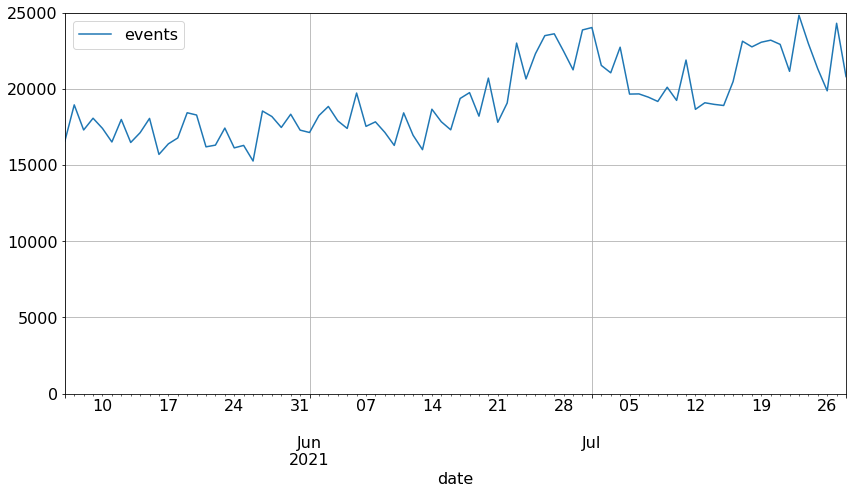

In [31]:
daily_events.plot(
    x="date",
    y="events",
    ylim=(0, 25000)
);

<div class="alert alert-box alert-warning">
Code below this point has not been updated to pull from the new storage table.
</div>

In [ ]:
wmf.presto.run(f"""
SELECT
    event.pageview_token AS pageview_id,
    event.session_id AS session_id,
    event.user_id AS user_id,
    MIN(FROM_ISO8601_TIMESTAMP(meta.dt)) AS start_time,
    MAX(
        -- Convert milliseconds to minutes
        CAST(event.page_visible_time AS REAL) / 1000 / 60
    ) AS page_viewing_min,
    -- If any users shift groups or countries, the aggregation
    -- results in an concatenated string, so those users can be identified and excluded
    ARRAY_JOIN(SET_AGG(geocoded_data['country_code']), '-') AS country,
    REDUCE(
        SET_UNION(event.tests), 
        NULL, 
        (i, x) -> IF(
            x.name = '2021-KaiOS-app-homepage-content-suggestions', 
            IF(i IS NULL, x."group", CONCAT(i, '-', x."group")),
            i
        ),
        x -> x
    ) AS experiment_group
FROM event.inukapageview
WHERE
    {PRESTO_PARTITION_DATE} >= '2021-05-06'
    AND geocoded_data['country_code'] IN ('NG', 'PK', 'TZ', 'UG')
    AND event.app_version >= '1.6.0'
    AND event.is_production
GROUP BY
    event.pageview_token,
    event.session_id,
    event.user_id
""")

In [150]:
user = wmf.presto.run(f"""
WITH pageview AS (

), session AS (
    SELECT
        session_id,
        user_id,
        MIN(start_time) AS start_time,
        SUM(page_viewing_min) AS page_viewing_min,
        ARRAY_JOIN(SET_AGG(country), '-') AS country,
        ARRAY_JOIN(SET_AGG(experiment_group), '-') AS experiment_group
    FROM pageview
    GROUP BY
        user_id,
        session_id
)
SELECT
    user_id,
    MIN(start_time) AS experiment_entry,
    CAST(DATE_DIFF('second', MIN(start_time), CURRENT_TIMESTAMP) AS REAL) / 60 / 60 / 24  AS days_in_experiment,
    COUNT(1) AS sessions,
    AVG(page_viewing_min) AS mean_session_min,
    ARRAY_JOIN(SET_AGG(country), '-') AS country,
    ARRAY_JOIN(SET_AGG(experiment_group), '-') AS experiment_group
FROM session
GROUP BY user_id
""").assign(
    experiment_entry=lambda df: pd.to_datetime(df["experiment_entry"]),
    country=lambda df: df["country"].astype("category"),
    experiment_group=lambda df: df["experiment_group"].astype("category")
)

In [151]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40280 entries, 0 to 40279
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   user_id             40280 non-null  object             
 1   experiment_entry    40280 non-null  datetime64[ns, UTC]
 2   days_in_experiment  40280 non-null  float64            
 3   sessions            40280 non-null  int64              
 4   mean_session_min    40280 non-null  float64            
 5   country             40280 non-null  category           
 6   experiment_group    40280 non-null  category           
dtypes: category(2), datetime64[ns, UTC](1), float64(2), int64(1), object(1)
memory usage: 1.6+ MB


# Data exploration

## Countries and experiment groups

In [155]:
pd.pivot_table(
    user, 
    values="sessions",
    index="country",
    columns="experiment_group",
    aggfunc=len,
    margins=True
)

experiment_group,control,control-trending-articles,trending-articles,All
country,,,,
NG,2951.0,NaN,2866.0,5817
PK,9074.0,1.0,8985.0,18060
TZ,5480.0,NaN,5427.0,10907
UG,2760.0,NaN,2736.0,5496
All,20265.0,1.0,20014.0,40280


In [156]:
user = user.query("experiment_group != 'control-trending-articles'")

In [157]:
pd.pivot_table(
    user, 
    values="sessions",
    index="country",
    columns="experiment_group",
    aggfunc=len,
    margins=True
)

experiment_group,control,trending-articles,All
country,,,
NG,2951,2866,5817
PK,9074,8985,18059
TZ,5480,5427,10907
UG,2760,2736,5496
All,20265,20014,40279


## Session duration

In [158]:
user["mean_session_min"].describe()

count     40279.000000
mean         12.301713
std        1366.824488
min       -1536.844400
25%           0.352692
50%           1.082083
75%           2.557442
max      252486.750000
Name: mean_session_min, dtype: float64

In [159]:
with pd.option_context("display.min_rows", 20):
    display(user["mean_session_min"].sort_values(ascending=False))

22367    252486.750000
26075    101221.140000
20229     32997.098000
3540      12894.256000
12770       173.118800
565         123.104260
10919       112.887930
29620        95.226135
26123        89.274580
20043        86.432080
             ...      
30951         0.002975
22970         0.002767
2671          0.002467
37859         0.002417
26889         0.002067
27432         0.002050
28687         0.001900
14824         0.001167
24208        -0.675867
8842      -1536.844400
Name: mean_session_min, Length: 40279, dtype: float64

Some users have pathological session lengths. Let's remove them.

In [160]:
user = user.query("mean_session_min >= 0 and mean_session_min < 600")

In [173]:
user["mean_session_min"].describe()

count    40273.000000
mean         2.419461
std          4.671541
min          0.001167
25%          0.352717
50%          1.082025
75%          2.557000
max        173.118800
Name: mean_session_min, dtype: float64

In [164]:
# Proportion of users with mean session length of 10 minutes or more
print(pct_str(user["mean_session_min"][lambda x: x >= 10].pipe(len) / len(session)))

2.6%


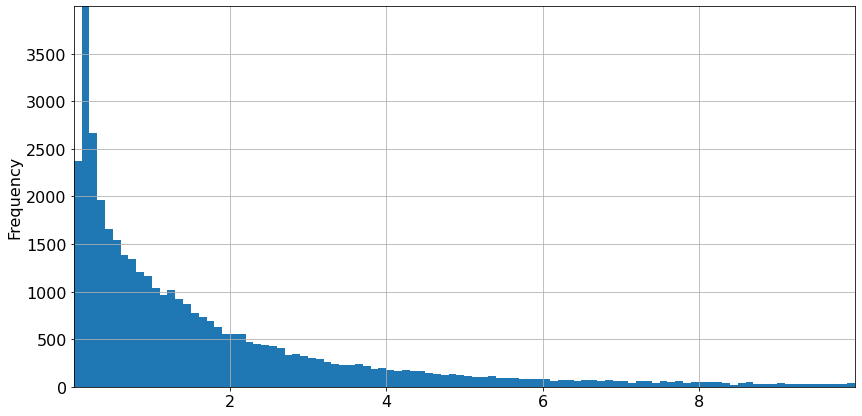

In [170]:
user["mean_session_min"][lambda x: x < 10].plot(kind='hist', bins=100);

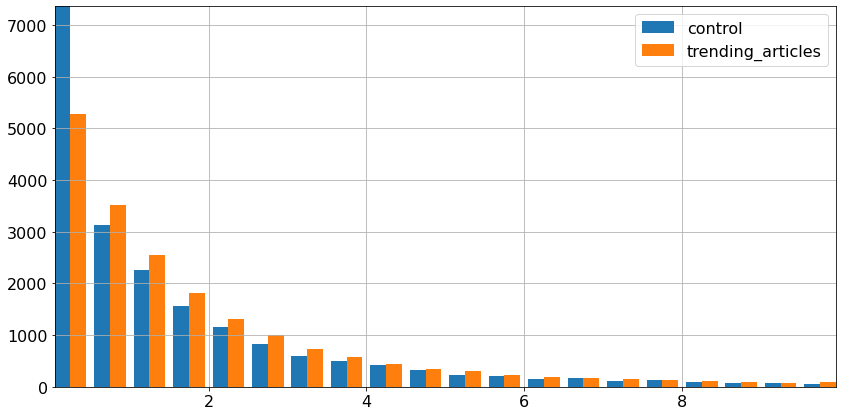

In [174]:
control_session_lengths = user.query("experiment_group == 'control'")["mean_session_min"][lambda x: x <= 10]
trending_articles_session_lengths = user.query("experiment_group == 'trending-articles'")["mean_session_min"][lambda x: x <= 10]

plt.hist([control_session_lengths, trending_articles_session_lengths], bins=20, label=["control", "trending_articles"])
plt.legend();

## Session count

In [175]:
user["sessions"].describe()

count    40273.000000
mean         1.684156
std          1.862584
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         91.000000
Name: sessions, dtype: float64

In [176]:
# Proportion of users with ten sessions or more
print(pct_str(user["sessions"][lambda x: x >= 10].pipe(len) / len(user)))

0.6%


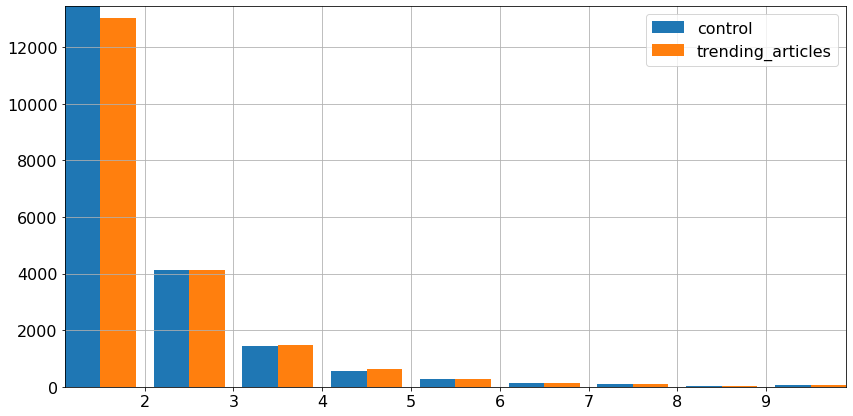

In [177]:
control_session_counts = user.query("experiment_group == 'control'")["sessions"][lambda x: x <= 10]
trending_articles_session_counts = user.query("experiment_group == 'trending-articles'")["sessions"][lambda x: x <= 10]

plt.hist([control_session_counts, trending_articles_session_counts], bins=9, label=["control", "trending_articles"])
plt.legend();

In [169]:
user["experiment_entry"].describe(datetime_is_numeric=True)

count                                  40273
mean     2021-05-29 16:19:25.548031744+00:00
min         2021-05-06 00:00:00.350000+00:00
25%         2021-05-16 16:42:52.168000+00:00
50%      2021-05-29 12:49:17.188999936+00:00
75%         2021-06-11 07:00:35.460000+00:00
max         2021-06-23 17:59:56.834000+00:00
Name: experiment_entry, dtype: object

In [171]:
user["days_in_experiment"].describe()

count    40273.000000
mean        25.193663
std         14.464636
min          0.123854
25%         12.581748
50%         25.339594
75%         38.177383
max         48.873814
Name: days_in_experiment, dtype: float64

## Correlations

/home/neilpquinn-wmf/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


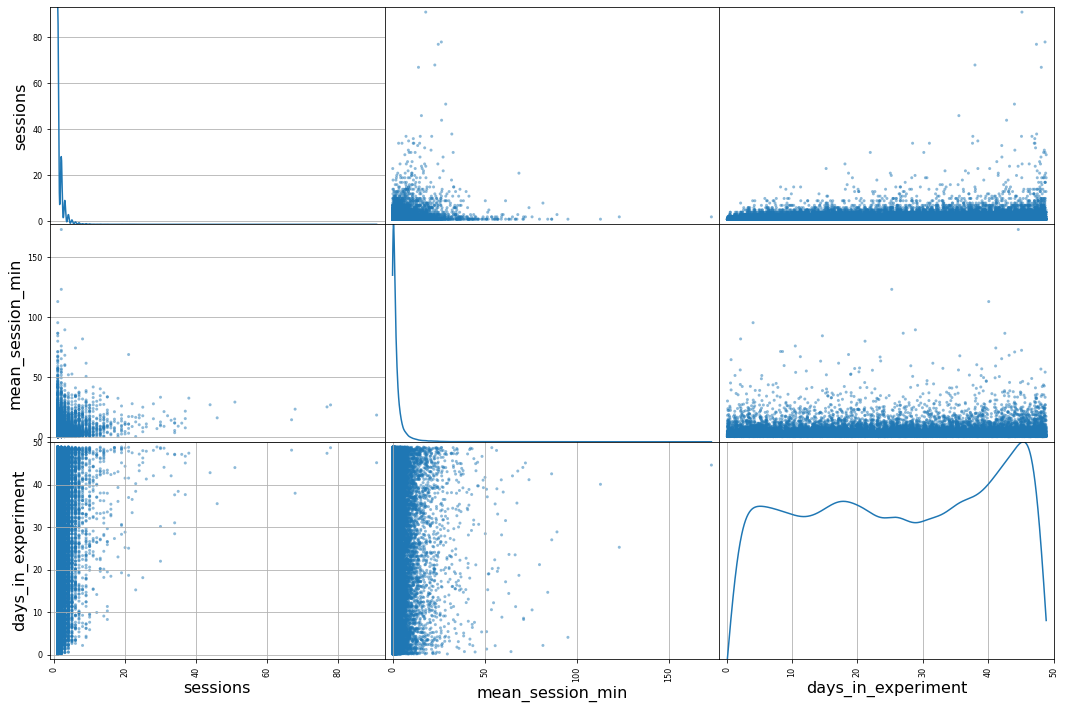

In [186]:
pd.plotting.scatter_matrix(
    user[["sessions", "mean_session_min", "days_in_experiment"]],
    diagonal="kde",
    figsize=(18, 12)
);

In [187]:
user.corr()

,days_in_experiment,sessions,mean_session_min
days_in_experiment,1.000000,0.122832,0.028551
sessions,0.122832,1.000000,0.209689
mean_session_min,0.028551,0.209689,1.000000


In [188]:
# We should actually save this as a timestamped file, so we can cleanly replicate the analysis
user.to_parquet('data/2021-06-24_experiment_user.parquet')